In [1]:
%load_ext autoreload
%autoreload 2

import pyVHR as vhr
import numpy as np
from pyVHR.analysis.pipeline import Pipeline
from pyVHR.plot.visualize import *
import os
import plotly.express as px
from pyVHR.utils.errors import getErrors, printErrors, displayErrors

import constants
import pandas as pd
import pyVHR.analysis.pipelineLandmarks as custom_pipeline

vhr.plot.VisualizeParams.renderer = 'vscode' 

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
import configparser
import ast
from numpy.lib.arraysetops import isin
import pandas as pd
import numpy as np
import time
from importlib import import_module, util
from pyVHR.datasets.dataset import datasetFactory
from pyVHR.utils.errors import getErrors, printErrors, displayErrors, BVP_windowing
from pyVHR.extraction.sig_processing import *
from pyVHR.extraction.sig_extraction_methods import *
from pyVHR.extraction.skin_extraction_methods import *
from pyVHR.BVP.BVP import *
from pyVHR.BPM.BPM import *
from pyVHR.BVP.methods import *
from pyVHR.BVP.filters import *
from inspect import getmembers, isfunction
import os.path
from pyVHR.deepRPPG.mtts_can import *
from pyVHR.deepRPPG.hr_cnn import *
from pyVHR.extraction.utils import *
from dtw import *
from scipy import signal
import scipy
import time
import steps

from tqdm import tqdm
from PIL import Image, ImageStat

In [3]:
# -- LOAD A DATASET

dataset_name = 'lgi_ppgi' 
winsize = 8        # seconds of video processed (with overlapping) for each estimate   

video_DIR, BVP_DIR = constants.get_dataset_paths(dataset_name)
videoFPS, sigFPS = constants.get_fps(dataset_name)
print(f"Video fps for {dataset_name} is {videoFPS}, Signal fps is {sigFPS} ")

dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames
videos = constants.get_video_settings(dataset_name)
print(videos)

# print the list of video names with the progressive index (idx)
for v in range(len(allvideo)):
  print(v, allvideo[v])

Video fps for lgi_ppgi is 25, Signal fps is 60 
{'GYM': array([ 0,  4,  8, 12, 16, 20]), 'STILL': array([ 1,  5,  9, 13, 17, 21]), 'ROTATION': array([ 2,  6, 10, 14, 18, 22]), 'TALK': array([ 3,  7, 11, 15, 19]), 'MALE': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23]), 'FEMALE': [0, 1, 2, 3], 'BEARD': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23]), 'GLASSES': [0, 1, 2, 3]}
0 D:/datasets_rppg/lgi_ppgi\alex\alex_gym\cv_camera_sensor_stream_handler.avi
1 D:/datasets_rppg/lgi_ppgi\alex\alex_resting\cv_camera_sensor_stream_handler.avi
2 D:/datasets_rppg/lgi_ppgi\alex\alex_rotation\cv_camera_sensor_stream_handler.avi
3 D:/datasets_rppg/lgi_ppgi\alex\alex_talk\cv_camera_sensor_stream_handler.avi
4 D:/datasets_rppg/lgi_ppgi\angelo\angelo_gym\cv_camera_sensor_stream_handler.avi
5 D:/datasets_rppg/lgi_ppgi\angelo\angelo_resting\cv_camera_sensor_stream_handler.avi
6 D:/datasets_rppg/lgi_ppgi\angelo\ange

videoFileName :  D:/datasets_rppg/lgi_ppgi\alex\alex_gym\cv_camera_sensor_stream_handler.avi
Video frame rate:      25 25.0
Length of the video: 1:05 min, timesGT is 402 s
Signal frame rate is 60 for LGI_PPGI and signal is  401.46666666666664 seconds worth


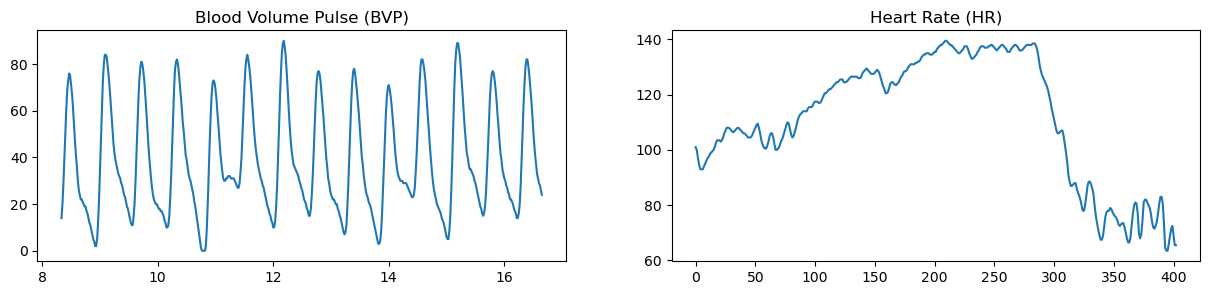

In [4]:
# -- PARAMETER SETTING

videoIdx = 0
fname = dataset.getSigFilename(videoIdx)
videoFileName = dataset.getVideoFilename(videoIdx)
fps = vhr.extraction.get_fps(videoFileName)
sigGT = dataset.readSigfile(fname)
bpmGT, timesGT = sigGT.getBPM(winsize) # STFT 42-240 BPM

print("videoFileName : ", videoFileName)
print('Video frame rate:     ',videoFPS, fps)
print(f"Length of the video: 1:05 min, timesGT is {len(timesGT)-1} s")
print(f"Signal frame rate is {sigFPS} for {dataset_name.upper()} and signal is ", sigGT.data.shape[1] / sigFPS, "seconds worth")

fig, ax = plt.subplots(1,2,figsize=(15,3))
ax[0].plot(np.arange(0, len(timesGT), 1/sigFPS)[500:1000], sigGT.data.T[500:1000])
ax[0].set_title('Blood Volume Pulse (BVP)')
ax[1].plot(timesGT, bpmGT)
ax[1].set_title('Heart Rate (HR)')
plt.show()

# Face brightness

- Use convex hull method to extract face
- Compute brightness of face 
- Adjust brightness of entire image to match the target face brightness

In [233]:
def get_sig_extractor(region_type, videoFPS):
      sig_extractor = vhr.extraction.SignalProcessing()
      sig_extractor.set_skin_extractor(vhr.extraction.SkinExtractionConvexHull('GPU'))

      # set the number of seconds (0 for all video)
      seconds = 60
      sig_extractor.set_total_frames(seconds*videoFPS)

      # -- SET VISUALIZATION MODE 
      sig_extractor.set_visualize_skin_and_landmarks(
            visualize_skin=True, 
            visualize_landmarks=True, 
            visualize_landmarks_number=True, 
            visualize_patch=True)

      return sig_extractor

def get_brightness(frame):
   """
      Convert image to greyscale, return average pixel brightness.
   """
   im =  Image.fromarray(frame).convert('L')
   stat = ImageStat.Stat(im)
   return stat.mean[0]

def change_brightness(img, value=0):
    """
      img: array
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def brighten_frames(videoFileName, sig_extractor, target_brightness, ratio):
    sig_extractor.cropped_skin_images = []
    sig_extractor.frame_images = []
    sig_extractor.brightned_images = []
    sig_extractor.face_brightness = []
    

    skin_ex = sig_extractor.skin_extractor

    mp_drawing = mp.solutions.drawing_utils
    mp_face_mesh = mp.solutions.face_mesh
    PRESENCE_THRESHOLD = 0.5
    VISIBILITY_THRESHOLD = 0.5

    sig = []
    processed_frames_count = 0

    with mp_face_mesh.FaceMesh(
            max_num_faces=1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5) as face_mesh:
        
        for frame in extract_frames_yield(videoFileName):
            # convert the BGR image to RGB.
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            processed_frames_count += 1
            width, height = image.shape[1], image.shape[0]
    
            ldmks = np.zeros((468, 5), dtype=np.float32)
            ldmks[:, 0] = -1.0
            ldmks[:, 1] = -1.0
            magic_ldmks = []
            ### face landmarks ###
            results = face_mesh.process(image)
            if results.multi_face_landmarks:
                face_landmarks = results.multi_face_landmarks[0]
                landmarks = [l for l in face_landmarks.landmark] # 468 Mediapipe keypoints
                for idx in range(len(landmarks)):
                    landmark = landmarks[idx]
                    if not ((landmark.HasField('visibility') and landmark.visibility < VISIBILITY_THRESHOLD)
                            or (landmark.HasField('presence') and landmark.presence < PRESENCE_THRESHOLD)):
                        coords = mp_drawing._normalized_to_pixel_coordinates(
                            landmark.x, landmark.y, width, height)
                        if coords:
                            ldmks[idx, 0] = coords[1]
                            ldmks[idx, 1] = coords[0]
                            
                ### skin extraction ###
                from pyVHR.extraction.sig_processing import MagicLandmarks
                aviable_ldmks = ldmks[ldmks[:,0] >= 0][:,:2]        
                hull = ConvexHull(aviable_ldmks)
                verts = [(aviable_ldmks[v,0], aviable_ldmks[v,1]) for v in hull.vertices]
                img = Image.new('L', image.shape[:2], 0)
                ImageDraw.Draw(img).polygon(verts, outline=1, fill=1)
                mask = np.array(img)
                mask = np.expand_dims(mask,axis=0).T
                full_skin_im = image * mask

                rmin, rmax, cmin, cmax = bbox2_GPU(cupy.asarray(full_skin_im))
                cropped_skin_im = full_skin_im
                if rmin >= 0 and rmax >= 0 and cmin >= 0 and cmax >= 0 and rmax-rmin >= 0 and cmax-cmin >= 0:
                    cropped_skin_im = full_skin_im[int(rmin):int(rmax), int(cmin):int(cmax)]

                # crop the face image to the center to discard black pixels around round face
                h,w = cropped_skin_im.shape[:2]
                cropped_skin_im = cropped_skin_im[int(w/ratio):int((ratio-1)*w/ratio), int(h/ratio):int((ratio-1)*h/ratio)]
                brightness = get_brightness(cropped_skin_im)
                value = int(target_brightness - brightness)
                brightned_image = change_brightness(frame, value=value)
                sig_extractor.face_brightness.append(brightness)


            else:
                cropped_skin_im = np.zeros_like(image)
                brightned_image = np.zeros_like(image)
            
            sig_extractor.cropped_skin_images.append(cropped_skin_im)    
            sig_extractor.frame_images.append(frame)  
            sig_extractor.brightned_images.append(brightned_image)  



            if sig_extractor.tot_frames is not None and sig_extractor.tot_frames > 0 and processed_frames_count >= sig_extractor.tot_frames:
                sig_extractor.average_brightness = np.mean(sig_extractor.face_brightness)
                sig_extractor.std_brightness = np.std(sig_extractor.face_brightness)
                break
    
    return sig_extractor
    

In [121]:
target_brightness = 140
ratio = 8

dataset_name = 'lgi_ppgi' 
result_path = f'D:/datasets_rppg/brightness_{target_brightness}/{dataset_name.upper()}/'

video_DIR, BVP_DIR = constants.get_dataset_paths(dataset_name)
videoFPS, sigvideoFPS = constants.get_fps(dataset_name)
dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames
datas = []

for i, videoFileName in enumerate(allvideo[1:2]):
    result_path = f'D:/datasets_rppg/brightness_{target_brightness}/{dataset_name.upper()}/'
    if dataset_name == 'mr_nirp':
        sname = videoFileName.split('\\')[-1][:-4]
    elif dataset_name == 'ubfc_phys':
        sname = videoFileName.split('\\')[-1].split('_')[1]
    elif dataset_name == 'lgi_ppgi':
        sname = videoFileName.split('\\')[-2]
    else:
        raise Exception('videoFileName for dataset not supported', dataset_name)
    fname = videoFileName.split('\\')[-1][:-4]

    # write also for non still videos just to keep videoIdx consistent
    if dataset_name.lower() == "ubfc_phys":
        if not os.path.exists(result_path + f'{sname}/'):
            os.makedirs(result_path + f'{sname}/')
        if "T1" not in videoFileName:
            if not os.path.exists(result_path + f'{sname}/{fname}.avi'):
                video = cv2.VideoWriter(result_path + f'{sname}/{fname}.avi', cv2.VideoWriter_fourcc(*'XVID'), videoFPS, (0, 0))
                video.release()
            continue
        result_path = result_path + f'{sname}/'

    if dataset_name.lower() == "mr_nirp" and "still" not in videoFileName:
        if not os.path.exists(result_path + f'{sname}.avi'):
            video = cv2.VideoWriter(result_path + f'{fname}.avi', cv2.VideoWriter_fourcc(*'XVID'), videoFPS, (0, 0))
            video.release()
        continue
    if dataset_name.lower() == 'lgi_ppgi':
        person, activity = videoFileName.split('\\')[-2].split('_')[0], videoFileName.split('\\')[-2].split('_')[1]
        if not os.path.exists(result_path + f'{person}/{person}_{activity}'):
            os.makedirs(result_path + f'{person}/{person}_{activity}')
        result_path = result_path + f'{person}/{person}_{activity}/'
    print("Processing video: ", videoFileName, "->", sname, result_path)

    sig_extractor = get_sig_extractor('landmark', videoFPS)
    sig_extractor = brighten_frames(videoFileName, sig_extractor, target_brightness, ratio)
    average_brightness = sig_extractor.average_brightness
    std_brightness = sig_extractor.std_brightness   

    height, width = sig_extractor.frame_images[0].shape[:-1]
    video = cv2.VideoWriter(result_path + f'{fname}.avi', cv2.VideoWriter_fourcc(*'XVID'), videoFPS, (width, height))
    for frame in sig_extractor.brightned_images:
        video.write(frame)
    video.release()
    datas.append([dataset_name, sname, average_brightness, std_brightness])

Processing video:  D:/datasets_rppg/lgi_ppgi\alex\alex_resting\cv_camera_sensor_stream_handler.avi -> alex_resting D:/datasets_rppg/brightness_100/LGI_PPGI/alex/alex_resting/


In [12]:
df = pd.DataFrame(datas, columns=['dataset', 'video', 'average_brightness', 'std_brightness'])
df.head()

,dataset,video,average_brightness,std_brightness
0,mr_nirp,Subject1_still_940,45.029081,0.249019
1,mr_nirp,Subject2_still_940,71.103532,0.248449
2,mr_nirp,Subject3_still_940,57.164871,0.242524
3,mr_nirp,Subject4_still_940,72.688838,0.663070
4,mr_nirp,Subject5_still_940,71.444167,0.608233


In [13]:
df.to_csv(f'../results/brightness_{target_brightness}/{dataset_name.upper()}/face_brightness.csv', index=False)  # save the dataframe to a csv file

67.92836652733382
89.50152560083595


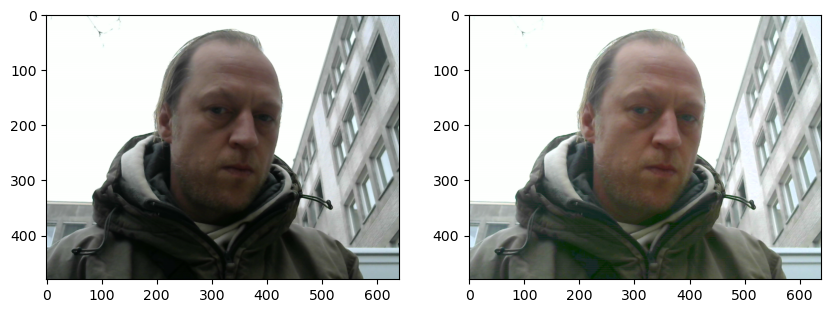

In [21]:
idx = 340
original = sig_extractor.frame_images[idx]
print(sig_extractor.face_brightness[idx])   
frame = sig_extractor.brightned_images[idx]

skin_ex = sig_extractor.skin_extractor

mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh
PRESENCE_THRESHOLD = 0.5
VISIBILITY_THRESHOLD = 0.5

sig = []
processed_frames_count = 0


with mp_face_mesh.FaceMesh(
        max_num_faces=1,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as face_mesh:
    # convert the BGR image to RGB.
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    width, height = image.shape[1], image.shape[0]
    ldmks = np.zeros((468, 5), dtype=np.float32)
    ldmks[:, 0] = -1.0
    ldmks[:, 1] = -1.0
    magic_ldmks = []
    ### face landmarks ###
    results = face_mesh.process(image)
    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]
        landmarks = [l for l in face_landmarks.landmark] # 468 Mediapipe keypoints
        for idx in range(len(landmarks)):
            landmark = landmarks[idx]
            if not ((landmark.HasField('visibility') and landmark.visibility < VISIBILITY_THRESHOLD)
                    or (landmark.HasField('presence') and landmark.presence < PRESENCE_THRESHOLD)):
                coords = mp_drawing._normalized_to_pixel_coordinates(
                    landmark.x, landmark.y, width, height)
                if coords:
                    ldmks[idx, 0] = coords[1]
                    ldmks[idx, 1] = coords[0]
                    
        ### skin extraction ###
        from pyVHR.extraction.sig_processing import MagicLandmarks
        aviable_ldmks = ldmks[ldmks[:,0] >= 0][:,:2]        
        hull = ConvexHull(aviable_ldmks)
        verts = [(aviable_ldmks[v,0], aviable_ldmks[v,1]) for v in hull.vertices]
        img = Image.new('L', image.shape[:2], 0)
        ImageDraw.Draw(img).polygon(verts, outline=1, fill=1)
        mask = np.array(img)
        mask = np.expand_dims(mask,axis=0).T
        full_skin_im = image * mask

        rmin, rmax, cmin, cmax = bbox2_GPU(cupy.asarray(full_skin_im))
        cropped_skin_im = full_skin_im
        if rmin >= 0 and rmax >= 0 and cmin >= 0 and cmax >= 0 and rmax-rmin >= 0 and cmax-cmin >= 0:
            cropped_skin_im = full_skin_im[int(rmin):int(rmax), int(cmin):int(cmax)]

        # crop the face image to the center to discard black pixels around round face
        h,w = cropped_skin_im.shape[:2]
        cropped_skin_im = cropped_skin_im[int(w/ratio):int((ratio-1)*w/ratio), int(h/ratio):int((ratio-1)*h/ratio)]
        brightness = get_brightness(cropped_skin_im)
        print(brightness)

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

Original image:  115.34244791666667
Entire  face:  20.56171415116553
Cropped Face brightness:  20.56171415116553 39
Brightned Image:  137.90920247395835


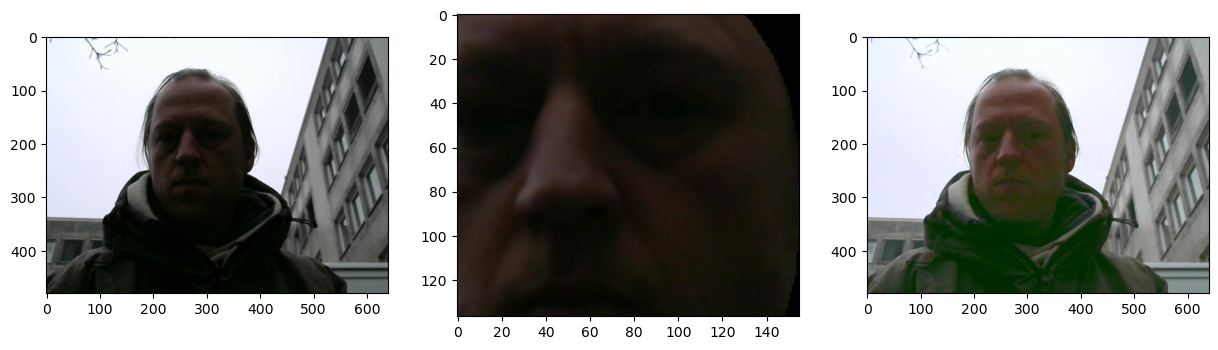

In [42]:
frame = 100
fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].imshow(cv2.cvtColor(sig_extractor.frame_images[frame], cv2.COLOR_BGR2RGB))

target_brightness = 60
cropped_skin_im = sig_extractor.cropped_skin_images[frame]
full_img = sig_extractor.frame_images[frame]
h,w = cropped_skin_im.shape[:2]
print("Original image: ", get_brightness(full_img))
print("Entire  face: ", get_brightness(cropped_skin_im))
brightness = get_brightness(cropped_skin_im)
value = int(target_brightness - brightness)
print("Cropped Face brightness: ",brightness, value) 
ax[1].imshow(cropped_skin_im) 

brightned_image = change_brightness(full_img, value=value)
print("Brightned Image: ", get_brightness(brightned_image))
ax[2].imshow(cv2.cvtColor(brightned_image, cv2.COLOR_BGR2RGB))

# ROI brightness

- Use convex hull method to extract face
- Compute brightness of face 
- Adjust brightness of ROI to match the target face brightness

In [46]:
def get_sig_extractor(region_type, videoFPS, seconds=60):
    sig_extractor = vhr.extraction.SignalProcessing()
    sig_extractor.set_skin_extractor(vhr.extraction.SkinExtractionConvexHull('GPU'))

    # set the number of seconds (0 for all video)
    sig_extractor.set_total_frames(seconds*videoFPS)

    # -- SET VISUALIZATION MODE 
    sig_extractor.set_visualize_skin_and_landmarks(
        visualize_skin=True, 
        visualize_landmarks=True, 
        visualize_landmarks_number=True, 
        visualize_patch=True)
      
    ldmks_list = [x for x in list(vhr.extraction.CustomLandmarks().__dict__)]
    all_landmarks  = vhr.extraction.CustomLandmarks().get_all_landmarks()
    landmarks = [all_landmarks[ldmk] for ldmk in ldmks_list]
    sig_extractor.set_landmarks(landmarks)

    sampling_method = 'all'
    nb_sample_points = 100
    sig_extractor.visualize_landmark = False 
    sig_extractor.visualize_patch = False 
    sig_extractor.set_patch_sampling(sampling_method=sampling_method, nb_sample_points=nb_sample_points)

    return sig_extractor

def get_brightness(frame):
   """
      Convert image to greyscale, return average pixel brightness.
   """
   im =  Image.fromarray(frame).convert('L')
   stat = ImageStat.Stat(im)
   return stat.mean[0]

def change_brightness(img, value=0):
    """
      img: array
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

from matplotlib.path import Path
def sort_coordinates(list_of_xy_coords):
    cx, cy = list_of_xy_coords.mean(0)
    x, y = list_of_xy_coords.T
    angles = np.arctan2(x-cx, y-cy)
    indices = np.argsort(angles)
    return list_of_xy_coords[indices]

def landmarks_path_mean(ldmks, im, sampling_method, nb_sample_points, RGB_LOW_TH, RGB_HIGH_TH):
    ldmks = sort_coordinates(ldmks[:,0:2])
    r_ldmks = np.zeros((1,5), dtype=np.float32)
    lds_mean = np.zeros(3, dtype=np.float32)

    polygon_path = Path(ldmks[:,::-1])
    top_left = np.min(ldmks, axis=0).astype(int)
    bottom_right = np.max(ldmks, axis=0).astype(int)
    x, y = np.meshgrid(np.arange(top_left[1], bottom_right[1]+1), np.arange(top_left[0], bottom_right[0]+1)) # (c,r)
    x, y = x.flatten(), y.flatten()
    pixel_coordinates = np.vstack((x,y)).T
    grid = polygon_path.contains_points(pixel_coordinates)
    pixel_coordinates = pixel_coordinates[grid][:,::-1] # (r,c)
    if sampling_method == 'random': # randomly sample from pixel_coordinates
        nb_sample_points = min(nb_sample_points, len(pixel_coordinates))
        pixel_coordinates = pixel_coordinates[np.random.choice(len(pixel_coordinates), nb_sample_points, replace=False)]

    pixel_coordinates = np.array(pixel_coordinates)
    num_elems = len(pixel_coordinates)
    
    for (x,y) in pixel_coordinates:
        if not((im[x, y, 0] <= RGB_LOW_TH and im[x, y, 1] <= RGB_LOW_TH and im[x, y, 2] <= RGB_LOW_TH) or
                (im[x, y, 0] >= RGB_HIGH_TH and im[x, y, 1] >= RGB_HIGH_TH and im[x, y, 2] >= RGB_HIGH_TH)):
            lds_mean[0] += np.float32(im[x, y, 0])
            lds_mean[1] += np.float32(im[x, y, 1])
            lds_mean[2] += np.float32(im[x, y, 2])

    if num_elems > 1.0:
        r_ldmks[:, 2] = lds_mean[0] / num_elems
        r_ldmks[:, 3] = lds_mean[1] / num_elems
        r_ldmks[:, 4] = lds_mean[2] / num_elems
        
    return r_ldmks, pixel_coordinates

def brighten_frames_roi(videoFileName, sig_extractor, ldmk_dict, roi_brightness):

    RGB_LOW_TH = np.int32(SignalProcessingParams.RGB_LOW_TH)
    RGB_HIGH_TH = np.int32(SignalProcessingParams.RGB_HIGH_TH)

    sig_extractor.frame_images = []
    sig_extractor.brightned_images = []

    skin_ex = sig_extractor.skin_extractor

    mp_drawing = mp.solutions.drawing_utils
    mp_face_mesh = mp.solutions.face_mesh
    PRESENCE_THRESHOLD = 0.5
    VISIBILITY_THRESHOLD = 0.5

    sig = []
    processed_frames_count = 0
    sig_extractor.patch_landmarks = []  

    with mp_face_mesh.FaceMesh(
            max_num_faces=1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5) as face_mesh:
        
        for frame in extract_frames_yield(videoFileName):
            # convert the BGR image to RGB.
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            processed_frames_count += 1
            width, height = image.shape[1], image.shape[0]
            brighter_frame = frame.copy()


            ldmks = np.zeros((468, 5), dtype=np.float32)
            ldmks[:, 0] = -1.0
            ldmks[:, 1] = -1.0
            magic_ldmks = []
            ldmk_brightness = {}
            ### face landmarks ###
            results = face_mesh.process(image)
            if results.multi_face_landmarks:
                face_landmarks = results.multi_face_landmarks[0]
                landmarks = [l for l in face_landmarks.landmark] # 468 Mediapipe keypoints
                for idx in range(len(landmarks)):
                    landmark = landmarks[idx]
                    if not ((landmark.HasField('visibility') and landmark.visibility < VISIBILITY_THRESHOLD)
                            or (landmark.HasField('presence') and landmark.presence < PRESENCE_THRESHOLD)):
                        coords = mp_drawing._normalized_to_pixel_coordinates(
                            landmark.x, landmark.y, width, height)
                        if coords:
                            ldmks[idx, 0] = coords[1]
                            ldmks[idx, 1] = coords[0]

                cropped_skin_im, full_skin_im = skin_ex.extract_skin(image, ldmks)

                for region in sig_extractor.ldmks:
                    keypoints = np.empty((len(region), 5))
                    for i,idx in enumerate(region):
                        keypoints[i] = ldmks[idx]
                    magic_ldmks.append(keypoints)  # coordinates of selected landmarks keypoints  
                temp = np.empty((len(magic_ldmks),5))
                for i,region in enumerate(magic_ldmks):
                    temp[i,:], pixel_coordinates = landmarks_path_mean(region, full_skin_im, sig_extractor.sampling_method, sig_extractor.nb_sample_points, RGB_LOW_TH, RGB_HIGH_TH)
                    if pixel_coordinates.shape[0] != 0:
                        pixel_values = frame[pixel_coordinates[:,0], pixel_coordinates[:,1]]                    
                        brightness = get_brightness(pixel_values)
                        target_brightness = roi_brightness[ldmk_dict[i]]
                        value = int(target_brightness - brightness)
                        brightner_pixel_values = change_brightness(np.expand_dims(pixel_values, axis=0), value=value)
                        brighter_frame[pixel_coordinates[:,0], pixel_coordinates[:,1]] = brightner_pixel_values[0]
            else:
                brighter_frame = np.zeros_like(image)
            
            try:
                sig.append(temp)
                sig_extractor.patch_landmarks.append([magic_ldmk[:,0:2] for magic_ldmk in magic_ldmks])
            except:
                continue
            sig_extractor.frame_images.append(frame)  
            sig_extractor.brightned_images.append(brighter_frame)  

            if sig_extractor.tot_frames is not None and sig_extractor.tot_frames > 0 and processed_frames_count >= sig_extractor.tot_frames:
            # if (sig_extractor.tot_frames is not None and sig_extractor.tot_frames > 0 and processed_frames_count >= sig_extractor.tot_frames) or processed_frames_count == 1:
                break
        
    return sig_extractor


In [ ]:
def get_sig_extractor(region_type, videoFPS, seconds=60):
    sig_extractor = vhr.extraction.SignalProcessing()
    sig_extractor.set_skin_extractor(vhr.extraction.SkinExtractionConvexHull('GPU'))

    # set the number of seconds (0 for all video)
    sig_extractor.set_total_frames(seconds*videoFPS)

    # -- SET VISUALIZATION MODE 
    sig_extractor.set_visualize_skin_and_landmarks(
        visualize_skin=True, 
        visualize_landmarks=True, 
        visualize_landmarks_number=True, 
        visualize_patch=True)
      
    ldmks_list = [x for x in list(vhr.extraction.CustomLandmarks().__dict__)]
    all_landmarks  = vhr.extraction.CustomLandmarks().get_all_landmarks()
    landmarks = [all_landmarks[ldmk] for ldmk in ldmks_list]
    sig_extractor.set_landmarks(landmarks)

    sampling_method = 'all'
    nb_sample_points = 100
    sig_extractor.visualize_landmark = False 
    sig_extractor.visualize_patch = False 
    sig_extractor.set_patch_sampling(sampling_method=sampling_method, nb_sample_points=nb_sample_points)

    return sig_extractor

def get_brightness(frame):
   """
      Convert image to greyscale, return average pixel brightness.
   """
   im =  Image.fromarray(frame).convert('L')
   stat = ImageStat.Stat(im)
   return stat.mean[0]

def change_brightness(img, value=0):
    """
      img: array
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

from matplotlib.path import Path
def sort_coordinates(list_of_xy_coords):
    cx, cy = list_of_xy_coords.mean(0)
    x, y = list_of_xy_coords.T
    angles = np.arctan2(x-cx, y-cy)
    indices = np.argsort(angles)
    return list_of_xy_coords[indices]


def landmarks_path_mean(ldmks, im, sampling_method, nb_sample_points, RGB_LOW_TH, RGB_HIGH_TH, roi_brightness):
    def sort_coordinates(list_of_xy_coords):
        cx, cy = list_of_xy_coords.mean(0)
        x, y = list_of_xy_coords.T
        angles = np.arctan2(x-cx, y-cy)
        indices = np.argsort(angles)
        return list_of_xy_coords[indices]
    
    ldmks = sort_coordinates(ldmks[:,0:2]) # works with (c,r) coordinates
    r_ldmks = np.zeros((1,5), dtype=np.float32)
    lds_mean = np.zeros(3, dtype=np.float32)

    polygon_path = Path(ldmks[:,::-1]) # works with (r,c) coordinates
    top_left = np.min(ldmks, axis=0).astype(int)
    bottom_right = np.max(ldmks, axis=0).astype(int)

    x, y = np.meshgrid(np.arange(top_left[1], bottom_right[1]+1), np.arange(top_left[0], bottom_right[0]+1)) # (c,r)
    x, y = x.flatten(), y.flatten()
    pixel_coordinates = np.vstack((x,y)).T
    grid = polygon_path.contains_points(pixel_coordinates)
    pixel_coordinates = pixel_coordinates[grid][:,::-1] # (r,c)
    if sampling_method == 'all':
        pass
    elif sampling_method == 'random': # randomly sample from pixel_coordinates
        nb_sample_points = min(nb_sample_points, len(pixel_coordinates))
        pixel_coordinates = pixel_coordinates[np.random.choice(len(pixel_coordinates), nb_sample_points, replace=False)]
    # if sampling_method == 'corner':
    #     pixel_coordinates = ldmks.astype(int)
    else:
        raise ValueError('sampling must be either \'all\' or \'random\'', sampling_method)
    pixel_coordinates = np.array(pixel_coordinates)
    num_elems = len(pixel_coordinates)

    if pixel_coordinates.shape[0] != 0:
        pixel_values = im[pixel_coordinates[:,0], pixel_coordinates[:,1]]                    
        brightness = get_brightness(pixel_values)
        target_brightness = roi_brightness
        value = int(target_brightness - brightness)
        brightner_pixel_values = change_brightness(np.expand_dims(pixel_values, axis=0), value=value)
        im[pixel_coordinates[:,0], pixel_coordinates[:,1]] = brightner_pixel_values[0]
    
    for (x,y) in pixel_coordinates:
        if not((im[x, y, 0] <= RGB_LOW_TH and im[x, y, 1] <= RGB_LOW_TH and im[x, y, 2] <= RGB_LOW_TH) or
                (im[x, y, 0] >= RGB_HIGH_TH and im[x, y, 1] >= RGB_HIGH_TH and im[x, y, 2] >= RGB_HIGH_TH)):
            lds_mean[0] += np.float32(im[x, y, 0])
            lds_mean[1] += np.float32(im[x, y, 1])
            lds_mean[2] += np.float32(im[x, y, 2])

    if num_elems > 1.0:
        r_ldmks[:, 2] = lds_mean[0] / num_elems
        r_ldmks[:, 3] = lds_mean[1] / num_elems
        r_ldmks[:, 4] = lds_mean[2] / num_elems
        
    return r_ldmks, im


def brighten_frames_roi(videoFileName, sig_extractor, ldmk_dict, roi_brightness):

    RGB_LOW_TH = np.int32(SignalProcessingParams.RGB_LOW_TH)
    RGB_HIGH_TH = np.int32(SignalProcessingParams.RGB_HIGH_TH)

    sig_extractor.frame_images = []
    sig_extractor.brightned_images = []

    skin_ex = sig_extractor.skin_extractor

    mp_drawing = mp.solutions.drawing_utils
    mp_face_mesh = mp.solutions.face_mesh
    PRESENCE_THRESHOLD = 0.5
    VISIBILITY_THRESHOLD = 0.5

    sig = []
    processed_frames_count = 0
    sig_extractor.patch_landmarks = []  

    with mp_face_mesh.FaceMesh(
            max_num_faces=1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5) as face_mesh:
        
        for frame in extract_frames_yield(videoFileName):
            # convert the BGR image to RGB.
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            processed_frames_count += 1
            width, height = image.shape[1], image.shape[0]
            brighter_frame = frame.copy()


            ldmks = np.zeros((468, 5), dtype=np.float32)
            ldmks[:, 0] = -1.0
            ldmks[:, 1] = -1.0
            magic_ldmks = []
            ldmk_brightness = {}
            ### face landmarks ###
            results = face_mesh.process(image)
            if results.multi_face_landmarks:
                face_landmarks = results.multi_face_landmarks[0]
                landmarks = [l for l in face_landmarks.landmark] # 468 Mediapipe keypoints
                for idx in range(len(landmarks)):
                    landmark = landmarks[idx]
                    if not ((landmark.HasField('visibility') and landmark.visibility < VISIBILITY_THRESHOLD)
                            or (landmark.HasField('presence') and landmark.presence < PRESENCE_THRESHOLD)):
                        coords = mp_drawing._normalized_to_pixel_coordinates(
                            landmark.x, landmark.y, width, height)
                        if coords:
                            ldmks[idx, 0] = coords[1]
                            ldmks[idx, 1] = coords[0]

                cropped_skin_im, full_skin_im = skin_ex.extract_skin(image, ldmks)

                for region in sig_extractor.ldmks:
                    keypoints = np.empty((len(region), 5))
                    for i,idx in enumerate(region):
                        keypoints[i] = ldmks[idx]
                    magic_ldmks.append(keypoints)  # coordinates of selected landmarks keypoints  
                temp = np.empty((len(magic_ldmks),5))
                for i,region in enumerate(magic_ldmks):
                    target_brightness = roi_brightness[ldmk_dict[i]]
                    temp[i,:], brighter_frame = landmarks_path_mean(region, full_skin_im, sig_extractor.sampling_method, sig_extractor.nb_sample_points, RGB_LOW_TH, RGB_HIGH_TH, target_brightness)

            else:
                brighter_frame = np.zeros_like(image)
            
            try:
                sig.append(temp)
                sig_extractor.patch_landmarks.append([magic_ldmk[:,0:2] for magic_ldmk in magic_ldmks])
            except:
                continue
            sig_extractor.frame_images.append(frame)  
            sig_extractor.brightned_images.append(brighter_frame)  

            if sig_extractor.tot_frames is not None and sig_extractor.tot_frames > 0 and processed_frames_count >= sig_extractor.tot_frames:
            # if (sig_extractor.tot_frames is not None and sig_extractor.tot_frames > 0 and processed_frames_count >= sig_extractor.tot_frames) or processed_frames_count == 1:
                break
        
    return sig_extractor


In [47]:
dataset_name = 'mr_nirp' 
setting = 'roi_80'
save = False

video_DIR, BVP_DIR = constants.get_dataset_paths(dataset_name)
videoFPS, sigvideoFPS = constants.get_fps(dataset_name)
dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames

sig_extractor = get_sig_extractor('landmark', videoFPS, seconds=30)
ldmk_names = [x for x in list(vhr.extraction.CustomLandmarks().__dict__)]
ldmk_dict = vhr.extraction.CustomLandmarks().get_all_landmarks()
ldmk_dict = {tuple(value):key for key, value in ldmk_dict.items()}
ldmk_dict = {i: ldmk_dict[tuple(ldmk)] for i,ldmk in enumerate(sig_extractor.ldmks)}

df_roi = pd.read_csv(f'../results/brightness_roi/{setting}/best_roi_brightness.csv')
roi_brightness = dict([(x['landmarks'], x['target']) for x in df_roi[['landmarks','target']].to_dict('records')])
roi_brightness = dict([(name, roi_brightness[name.replace('left_', '').replace('right_', '')]) for name in ldmk_names])

datas = []

for i, videoFileName in enumerate(allvideo[3:4]):
    result_path = f'D:/datasets_rppg/brightness_roi/{setting}/{dataset_name.upper()}/'
    if dataset_name == 'mr_nirp':
        sname = videoFileName.split('\\')[-1][:-4]
    elif dataset_name == 'ubfc_phys':
        sname = videoFileName.split('\\')[-1].split('_')[1]
    elif dataset_name == 'lgi_ppgi':
        sname = videoFileName.split('\\')[-2]
    else:
        raise Exception('videoFileName for dataset not supported', dataset_name)
    fname = videoFileName.split('\\')[-1][:-4]

    # write also for non still videos just to keep videoIdx consistent
    if dataset_name.lower() == "ubfc_phys" and "T1" not in videoFileName:
        if save:
            if not os.path.exists(result_path + f'{sname}/'):
                os.makedirs(result_path + f'{sname}/')
            if not os.path.exists(result_path + f'{sname}/{fname}.avi'):
                video = cv2.VideoWriter(result_path + f'{sname}/{fname}.avi', cv2.VideoWriter_fourcc(*'XVID'), videoFPS, (0, 0))
                video.release()
        continue
    if dataset_name.lower() == "mr_nirp" and "still" not in videoFileName:
        if save:
            if not os.path.exists(result_path + f'{sname}.avi'):
                video = cv2.VideoWriter(result_path + f'{fname}.avi', cv2.VideoWriter_fourcc(*'XVID'), videoFPS, (0, 0))
                video.release()
        continue
    if dataset_name.lower() == 'lgi_ppgi':
        person, activity = videoFileName.split('\\')[-2].split('_')[0], videoFileName.split('\\')[-2].split('_')[1]
        if save:
            if not os.path.exists(result_path + f'{person}/{person}_{activity}'):
                os.makedirs(result_path + f'{person}/{person}_{activity}')
            result_path = result_path + f'{person}/{person}_{activity}/'
            if not os.path.exists(result_path + f'{fname}.avi'):
                video = cv2.VideoWriter(result_path + f'{fname}.avi', cv2.VideoWriter_fourcc(*'XVID'), videoFPS, (0, 0))
                video.release()
        else:   
            result_path = result_path + f'{person}/{person}_{activity}/'

        # if activity != 'resting':
        #     continue
    print("Processing video: ", videoFileName, "->", sname, result_path)

    sig_extractor = get_sig_extractor('landmark', videoFPS, seconds=30)
    sig_extractor.roi_brightness = {name: [] for name in ldmk_names}
    sig_extractor = brighten_frames_roi(videoFileName, sig_extractor, ldmk_dict, roi_brightness)

    height, width = sig_extractor.frame_images[0].shape[:-1]
    if save:
        video = cv2.VideoWriter(result_path + f'{fname}.avi', cv2.VideoWriter_fourcc(*'XVID'), videoFPS, (width, height))
        for frame in sig_extractor.brightned_images:
            video.write(frame)
        video.release()

Processing video:  D:/datasets_rppg/MR-NIRP_indoor\Subject2_still_940-002\Subject2_still_940\RGB_corrected\Subject2_still_940.avi -> Subject2_still_940 D:/datasets_rppg/brightness_roi/roi_80/MR_NIRP/


KeyboardInterrupt: 

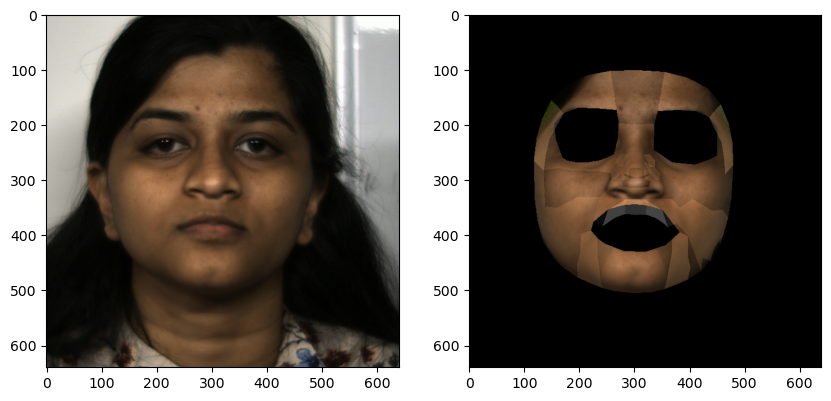

In [49]:
idx = 120
original = sig_extractor.frame_images[idx]
frame = sig_extractor.brightned_images[idx]
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
# ax[1].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
ax[1].imshow(frame)

# Get ROI brightness

In [57]:
def get_sig_extractor(region_type, videoFPS, seconds=60):
    sig_extractor = vhr.extraction.SignalProcessing()
    sig_extractor.set_skin_extractor(vhr.extraction.SkinExtractionConvexHull('GPU'))

    # set the number of seconds (0 for all video)
    sig_extractor.set_total_frames(seconds*videoFPS)

    # -- SET VISUALIZATION MODE 
    sig_extractor.set_visualize_skin_and_landmarks(
        visualize_skin=True, 
        visualize_landmarks=True, 
        visualize_landmarks_number=True, 
        visualize_patch=True)
      
    ldmks_list = [x for x in list(vhr.extraction.CustomLandmarks().__dict__)]
    all_landmarks  = vhr.extraction.CustomLandmarks().get_all_landmarks()
    landmarks = [all_landmarks[ldmk] for ldmk in ldmks_list]
    sig_extractor.set_landmarks(landmarks)

    sampling_method = 'all'
    nb_sample_points = 100
    sig_extractor.visualize_landmark = False 
    sig_extractor.visualize_patch = False 
    sig_extractor.set_patch_sampling(sampling_method=sampling_method, nb_sample_points=nb_sample_points)

    return sig_extractor

def get_brightness(frame):
   """
      Convert image to greyscale, return average pixel brightness.
   """
   im =  Image.fromarray(frame).convert('L')
   stat = ImageStat.Stat(im)
   return stat.mean[0]

def change_brightness(img, value=0):
    """
      img: array
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

from matplotlib.path import Path
def sort_coordinates(list_of_xy_coords):
    cx, cy = list_of_xy_coords.mean(0)
    x, y = list_of_xy_coords.T
    angles = np.arctan2(x-cx, y-cy)
    indices = np.argsort(angles)
    return list_of_xy_coords[indices]

def landmarks_path_mean(ldmks, im, sampling_method, nb_sample_points, RGB_LOW_TH, RGB_HIGH_TH):
    ldmks = sort_coordinates(ldmks[:,0:2])
    r_ldmks = np.zeros((1,5), dtype=np.float32)
    lds_mean = np.zeros(3, dtype=np.float32)

    polygon_path = Path(ldmks[:,::-1])
    top_left = np.min(ldmks, axis=0).astype(int)
    bottom_right = np.max(ldmks, axis=0).astype(int)
    x, y = np.meshgrid(np.arange(top_left[1], bottom_right[1]+1), np.arange(top_left[0], bottom_right[0]+1)) # (c,r)
    x, y = x.flatten(), y.flatten()
    pixel_coordinates = np.vstack((x,y)).T
    grid = polygon_path.contains_points(pixel_coordinates)
    pixel_coordinates = pixel_coordinates[grid][:,::-1] # (r,c)
    if sampling_method == 'random': # randomly sample from pixel_coordinates
        nb_sample_points = min(nb_sample_points, len(pixel_coordinates))
        pixel_coordinates = pixel_coordinates[np.random.choice(len(pixel_coordinates), nb_sample_points, replace=False)]

    pixel_coordinates = np.array(pixel_coordinates)
    num_elems = len(pixel_coordinates)
    
    for (x,y) in pixel_coordinates:
        if not((im[x, y, 0] <= RGB_LOW_TH and im[x, y, 1] <= RGB_LOW_TH and im[x, y, 2] <= RGB_LOW_TH) or
                (im[x, y, 0] >= RGB_HIGH_TH and im[x, y, 1] >= RGB_HIGH_TH and im[x, y, 2] >= RGB_HIGH_TH)):
            lds_mean[0] += np.float32(im[x, y, 0])
            lds_mean[1] += np.float32(im[x, y, 1])
            lds_mean[2] += np.float32(im[x, y, 2])

    if num_elems > 1.0:
        r_ldmks[:, 2] = lds_mean[0] / num_elems
        r_ldmks[:, 3] = lds_mean[1] / num_elems
        r_ldmks[:, 4] = lds_mean[2] / num_elems
        
    return r_ldmks, pixel_coordinates

def get_brightness_roi(videoFileName, sig_extractor, target_brightness):
    RGB_LOW_TH = np.int32(SignalProcessingParams.RGB_LOW_TH)
    RGB_HIGH_TH = np.int32(SignalProcessingParams.RGB_HIGH_TH)

    sig_extractor.frame_images = []
    sig_extractor.brightned_images = []
    # sig_extractor.roi_brightness = []

    skin_ex = sig_extractor.skin_extractor

    mp_drawing = mp.solutions.drawing_utils
    mp_face_mesh = mp.solutions.face_mesh
    PRESENCE_THRESHOLD = 0.5
    VISIBILITY_THRESHOLD = 0.5

    sig = []
    processed_frames_count = 0

    with mp_face_mesh.FaceMesh(
            max_num_faces=1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5) as face_mesh:
        
        for frame in extract_frames_yield(videoFileName):
            # convert the BGR image to RGB.
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            processed_frames_count += 1
            width, height = image.shape[1], image.shape[0]
            brighter_frame = frame.copy()
            # if processed_frames_count % nb_frames_stride != 0:
            #     continue


            ldmks = np.zeros((468, 5), dtype=np.float32)
            ldmks[:, 0] = -1.0
            ldmks[:, 1] = -1.0
            magic_ldmks = []
            ldmk_brightness = {}
            ### face landmarks ###
            results = face_mesh.process(image)
            if results.multi_face_landmarks:
                face_landmarks = results.multi_face_landmarks[0]
                landmarks = [l for l in face_landmarks.landmark] # 468 Mediapipe keypoints
                for idx in range(len(landmarks)):
                    landmark = landmarks[idx]
                    if not ((landmark.HasField('visibility') and landmark.visibility < VISIBILITY_THRESHOLD)
                            or (landmark.HasField('presence') and landmark.presence < PRESENCE_THRESHOLD)):
                        coords = mp_drawing._normalized_to_pixel_coordinates(
                            landmark.x, landmark.y, width, height)
                        if coords:
                            ldmks[idx, 0] = coords[1]
                            ldmks[idx, 1] = coords[0]

                cropped_skin_im, full_skin_im = skin_ex.extract_skin(image, ldmks)

                for region in sig_extractor.ldmks:
                    keypoints = np.empty((len(region), 5))
                    for i,idx in enumerate(region):
                        keypoints[i] = ldmks[idx]
                    magic_ldmks.append(keypoints)  # coordinates of selected landmarks keypoints  
                temp = np.empty((len(magic_ldmks),5))
                for i,region in enumerate(magic_ldmks):
                    temp[i,:], pixel_coordinates = landmarks_path_mean(region, full_skin_im, sig_extractor.sampling_method, sig_extractor.nb_sample_points, RGB_LOW_TH, RGB_HIGH_TH)
                    if pixel_coordinates.shape[0] != 0:
                        pixel_values = frame[pixel_coordinates[:,0], pixel_coordinates[:,1]]                    
                        brightness = get_brightness(pixel_values)
                        sig_extractor.roi_brightness[ldmk_dict[i]].append(brightness)
                    else:
                        sig_extractor.roi_brightness[ldmk_dict[i]].append(None)
            else:
                brighter_frame = np.zeros_like(image)
            
            sig_extractor.frame_images.append(frame)  

            if sig_extractor.tot_frames is not None and sig_extractor.tot_frames > 0 and processed_frames_count >= sig_extractor.tot_frames:
                break
            
    return sig_extractor


In [60]:
ratio = 8
target_brightness = 60

dataset_name = 'mr_nirp' 
result_path = f'D:/datasets_rppg/brightness_roi/brightness_{target_brightness}/{dataset_name.upper()}/'

video_DIR, BVP_DIR = constants.get_dataset_paths(dataset_name)
videoFPS, sigvideoFPS = constants.get_fps(dataset_name)
dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames

ldmk_names = [x for x in list(vhr.extraction.CustomLandmarks().__dict__)]
ldmk_dict = vhr.extraction.CustomLandmarks().get_all_landmarks()
ldmk_dict = {tuple(value):key for key, value in ldmk_dict.items()}
sig_extractor = get_sig_extractor('landmark', videoFPS, seconds=60)
ldmk_dict = {i: ldmk_dict[tuple(ldmk)] for i,ldmk in enumerate(sig_extractor.ldmks)}

datas = []

for i, videoFileName in enumerate(allvideo[1:2]):
    result_path = f'D:/datasets_rppg/brightness_roi/brightness_{target_brightness}/{dataset_name.upper()}/'
    if dataset_name == 'mr_nirp':
        sname = videoFileName.split('\\')[-1][:-4]
    elif dataset_name == 'ubfc_phys':
        sname = videoFileName.split('\\')[-1].split('_')[1]
    elif dataset_name == 'lgi_ppgi':
        sname = videoFileName.split('\\')[-2]
    else:
        raise Exception('videoFileName for dataset not supported', dataset_name)
    fname = videoFileName.split('\\')[-1][:-4]

    # write also for non still videos just to keep videoIdx consistent
    if dataset_name.lower() == "ubfc_phys" and "T1" not in videoFileName:
        continue
    if dataset_name.lower() == "mr_nirp" and "still" not in videoFileName:
        continue
    if dataset_name.lower() == 'lgi_ppgi':
        person, activity = videoFileName.split('\\')[-2].split('_')[0], videoFileName.split('\\')[-2].split('_')[1]
        result_path = result_path + f'{person}/{person}_{activity}/'
    print("Processing video: ", videoFileName, "->", sname, result_path)

    sig_extractor = get_sig_extractor('landmark', videoFPS, seconds=60)
    sig_extractor.roi_brightness = {name: [] for name in ldmk_names}
    sig_extractor = get_brightness_roi(videoFileName, sig_extractor, target_brightness)
    nb_frames_stride = int(sig_extractor.tot_frames / 6 )
    roi_brightness = {}
    for key, value in sig_extractor.roi_brightness.items():
        tmp = [np.mean([v for v in value[i:i+nb_frames_stride] if v is not None]) for i in range(0, len(value), nb_frames_stride)]
        roi_brightness[key] = tmp

    datas.append([dataset_name, sname, *list(roi_brightness.values())])


Processing video:  D:/datasets_rppg/MR-NIRP_indoor\Subject1_still_940-015\Subject1_still_940\RGB_corrected\Subject1_still_940.avi -> Subject1_still_940 D:/datasets_rppg/brightness_roi/brightness_60/MR_NIRP/


In [61]:
nb_frames_stride = int(sig_extractor.tot_frames / 6 )
print(nb_frames_stride, sig_extractor.tot_frames)
print(sig_extractor.roi_brightness['glabella'].shape)

300 1800


AttributeError: 'list' object has no attribute 'shape'

In [185]:
df = pd.DataFrame(datas, columns=['dataset', 'videoFilename'] + list(roi_brightness.keys()))
df.head()

,dataset,videoFilename,lower_medial_forehead,left_lower_lateral_forehead,right_lower_lateral_forehead,glabella,upper_nasal_dorsum,lower_nasal_dorsum,soft_triangle,left_ala,...,right_nasolabial_fold,left_temporal,right_temporal,left_malar,right_malar,left_lower_cheek,right_lower_cheek,chin,left_marionette_fold,right_marionette_fold
0,mr_nirp,Subject1_still_940,"[73.21960504392055, 72.6250303683947, 72.20839...","[60.97765972660643, 60.85296374571696, 60.5791...","[47.91933293181503, 47.35575342772424, 47.1760...","[75.33043667899346, 75.04974705707913, 74.8501...","[51.29544517579434, 51.37029104316739, 51.4904...","[73.37698061158406, 73.00107144425422, 72.5837...","[85.69386234056691, 86.87095831766443, 88.8400...","[76.56814711084856, 76.31963323935696, 75.6844...",...,"[32.72277788448465, 32.20998498728642, 32.2714...","[31.71778977088861, 31.95594258953611, 31.5795...","[19.25351812281718, 19.083246486896904, 18.574...","[62.31602428163449, 62.61603520985763, 63.3537...","[55.055943904570306, 55.03395050801979, 54.976...","[32.377852112656186, 32.84250836762952, 33.509...","[22.953505962516, 23.169612322732192, 23.27744...","[34.07645996591354, 33.71547995723447, 33.0971...","[26.53315107154526, 25.927003779634852, 25.172...","[18.391763753238497, 18.480079047645788, 18.15..."
1,mr_nirp,Subject2_still_940,"[108.08245607004402, 108.03333815744548, 107.1...","[81.10252983840351, 81.29963530828861, 80.7829...","[71.97644722503814, 72.1266016686845, 71.15850...","[107.7261699453425, 107.67506138853581, 106.85...","[80.09049214709698, 80.1215701195391, 79.29977...","[84.04542498556448, 83.97959884067738, 83.5634...","[115.95678227404103, 115.78854206036524, 115.7...","[95.82103311320937, 95.50467392537621, 95.5005...",...,"[66.09203751395668, 65.87017065610222, 65.3834...","[33.29440782239608, 33.39786201177307, 33.0092...","[26.404902099263328, 26.704229948053282, 26.16...","[106.40443584542562, 106.24209254816468, 106.1...","[82.31523235123764, 82.18630739963211, 81.5495...","[79.4175362478815, 79.47263515361865, 79.93514...","[53.775408486154326, 54.193316477951136, 54.31...","[70.38661924860136, 70.19497050424866, 70.4394...","[55.28905860471105, 55.04705283350276, 55.1761...","[37.96177043613401, 38.08996329259603, 38.2140..."
2,mr_nirp,Subject3_still_940,"[92.94920099684083, 92.83419681766154, 93.2346...","[68.28860546493732, 68.23057434897382, 68.2680...","[67.09967692950039, 67.22667925297452, 67.3549...","[89.14315733169552, 89.13915271108904, 89.2289...","[79.11892950033393, 79.36136787884233, 79.7453...","[95.43954102573578, 95.9292543183479, 96.71594...","[78.76280622924341, 78.71987035355014, 77.8350...","[70.7201971340291, 70.96758761221453, 70.86987...",...,"[34.446013675839225, 34.26014454826389, 34.233...","[45.01406429466747, 45.67838093671819, 45.6000...","[27.939151806852568, 28.202653541688722, 28.32...","[93.44065773783575, 93.55364063479239, 93.6520...","[65.48454621752563, 65.54774819948872, 65.6463...","[46.861320565071246, 47.14163294001134, 47.319...","[30.456062359863335, 30.399054803979197, 30.46...","[17.242002727353544, 17.001148609837276, 16.92...","[15.015670183215686, 15.095647247065921, 15.15...","[11.726091613425936, 11.732326895121988, 11.80..."
3,mr_nirp,Subject4_still_940,"[88.22716113723232, 90.08552014121898, 90.7137...","[88.83028199461506, 89.28397195955513, 88.6939...","[69.59380628675834, 70.74300880384548, 72.3323...","[100.41299785725099, 101.09012614262103, 100.8...","[83.5778212352367, 84.36114253796265, 85.04084...","[81.85859850557082, 83.1465084947257, 83.57218...","[81.05260310450906, 81.69506873045113, 82.5348...","[74.71834917146671, 75.15423568166429, 74.9838...",...,"[57.19700455143413, 58.51398997402112, 59.8919...","[48.26429367099208, 49.12643932828593, 49.3710...","[30.420075299406964, 30.646399941613492, 31.60...","[93.22247374176101, 95.27063691629616, 96.3083...","[75.99605296957948, 75.45900105192692, 76.0919...","[70.4581838785832, 70.87842557644353, 70.96068..."

In [186]:
df.to_csv(f'../results/no_overlap/{dataset_name.upper()}/roi_brightness.csv', index=False)  # save the dataframe to a csv file

# Compute brightness

90.67536167747139


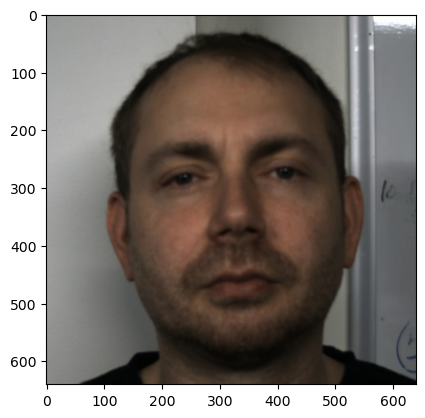

In [28]:
# import the necessary packages
from skimage.exposure import is_low_contrast
from numpy.linalg import norm
import cv2

videoIdx = 8
dataset_name = 'mr_nirp'
dataset = steps.get_dataset(dataset_name)
videoFileName = dataset.getVideoFilename(videoIdx)
cam = cv2.VideoCapture(videoFileName) 
ret,frame = cam.read() 
image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
brightness =  np.average(norm(image, axis=2)) / np.sqrt(3)
print(brightness)
plt.imshow(image)

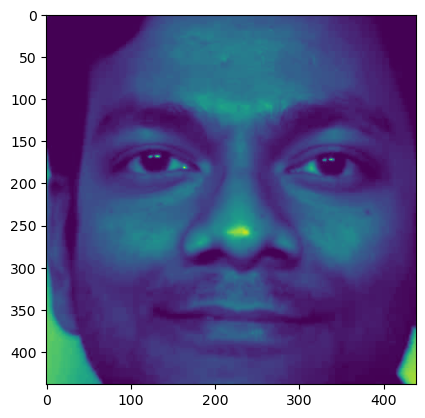

In [27]:
image =  cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)
face = face_classifier.detectMultiScale(
    image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40)
)
for (x, y, w, h) in face:
    image = image[y:y+h, x:x+w]
plt.imshow(image)

In [7]:
from PIL import Image, ImageStat

def brightness(frame):
   """
      Convert image to greyscale, return average pixel brightness.
   """
   im = Image.fromarray(frame).convert('L')
   stat = ImageStat.Stat(im)
   return stat.mean[0]

print(brightness(frame))

def brightness(frame):
   im = Image.fromarray(frame).convert('L')
   stat = ImageStat.Stat(im)
   return stat.rms[0]

print(brightness(frame))


def brightness( frame ):
   im = Image.fromarray(frame)
   stat = ImageStat.Stat(im)
   r,g,b = stat.mean
   return math.sqrt(0.241*(r**2) + 0.691*(g**2) + 0.068*(b**2))

print(brightness(frame))


def brightness( frame ):
   im = Image.fromarray(frame)
   stat = ImageStat.Stat(im)
   r,g,b = stat.rms
   return math.sqrt(0.241*(r**2) + 0.691*(g**2) + 0.068*(b**2))

print(brightness(frame))

def brightness(frame):
   img = Image.fromarray(frame)
   img_gray = img.convert('L')

   # Calculate the average pixel value
   histogram = img_gray.histogram()
   pixels = sum(histogram)
   brightness = scale = len(histogram)

   for index in range(0, scale):
      ratio = histogram[index] / pixels
      brightness += ratio * (-scale + index)
   print('  ', brightness)

   return 1 if brightness == 255 else brightness / scale

print(brightness(frame))

87.9844677734375
100.60960035985786
87.98710991976863
100.76864351867717
   87.98446777343757
0.3436893272399905


In [57]:
def get_brightness(frame):
   """
      Convert image to greyscale, return average pixel brightness.
   """
   im = frame.convert('L')
   stat = ImageStat.Stat(im)
   return stat.mean[0]

def get_video_average_brightness(video_path, fps):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    total_brightness = 0.0
    nb_frames_minute = fps * 60

    while cap.isOpened() and frame_count < nb_frames_minute:
        ret, frame = cap.read()
        if not ret:
            break

        pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        brightness = get_brightness(pil_image)
        total_brightness += brightness
        frame_count += 1

    cap.release()
    try:
        resolution = (frame.shape[1], frame.shape[0])   
    except:
        resolution = (0,0)
    # assert resolution[0] == resolution[1]
    
    # Calculate the average brightness over all frames
    if frame_count > 0:
        average_brightness = total_brightness / frame_count
        return average_brightness, resolution[0]
    else:
        return None, resolution[0]


datas = []

dataset_name = 'mr_nirp' 
video_DIR, BVP_DIR = constants.get_dataset_paths(dataset_name)
videoFPS, sigFPS = constants.get_fps(dataset_name)
dataset = steps.get_dataset(dataset_name,video_DIR='D:/datasets_rppg/brightness_60/MR_NIRP_indoor/')
allvideo = dataset.videoFilenames

for i, videoFileName in enumerate(allvideo):
    if dataset_name.lower() == "ubfc_phys" and "T1" not in videoFileName:
        continue
    average_brightness, resolution = get_video_average_brightness(videoFileName, videoFPS)

    if dataset_name == 'lgi_ppgi' or dataset_name == 'mr_nirp' or dataset_name == 'ubfc_phys':
        videoFileName = videoFileName.split('\\')[-1][:-4]
    else:
        raise Exception('videoFileName for dataset not supported', dataset_name)
    print(f"Average Brightness of {videoFileName}", average_brightness)

    datas.append([dataset_name, videoFileName, resolution, average_brightness])

df = pd.DataFrame(datas, columns=['dataset', 'videoFilename', 'resolution', 'brightness'])

D:/datasets_rppg/brightness_60/MR_NIRP_indoor/Subject1_motion_940.avi
Average Brightness of D:/datasets_rppg/brightness_60/MR_NIRP_indoor/Subject1_motion_940 None
D:/datasets_rppg/brightness_60/MR_NIRP_indoor/Subject1_still_940.avi
Average Brightness of D:/datasets_rppg/brightness_60/MR_NIRP_indoor/Subject1_still_940 63.986162527126694
D:/datasets_rppg/brightness_60/MR_NIRP_indoor/Subject2_motion_940.avi
Average Brightness of D:/datasets_rppg/brightness_60/MR_NIRP_indoor/Subject2_motion_940 None
D:/datasets_rppg/brightness_60/MR_NIRP_indoor/Subject2_still_940.avi
Average Brightness of D:/datasets_rppg/brightness_60/MR_NIRP_indoor/Subject2_still_940 64.74028479003917
D:/datasets_rppg/brightness_60/MR_NIRP_indoor/Subject3_motion_940.avi
Average Brightness of D:/datasets_rppg/brightness_60/MR_NIRP_indoor/Subject3_motion_940 None
D:/datasets_rppg/brightness_60/MR_NIRP_indoor/Subject3_still_940.avi
Average Brightness of D:/datasets_rppg/brightness_60/MR_NIRP_indoor/Subject3_still_940 63.070

KeyboardInterrupt: 

In [13]:
df

,dataset,videoFilename,resolution,brightness
0,mr_nirp,Subject1_motion_940,640,80.249016
1,mr_nirp,Subject1_still_940,640,77.034276
2,mr_nirp,Subject2_motion_940,640,74.084667
3,mr_nirp,Subject2_still_940,640,73.592129
4,mr_nirp,Subject3_motion_940,640,78.512421
5,mr_nirp,Subject3_still_940,640,71.610903
6,mr_nirp,Subject4_motion_940,640,79.774539
7,mr_nirp,Subject4_still_940,640,83.308350
8,mr_nirp,Subject5_still_940,640,91.618412
9,mr_nirp,Subject6_motion_940,848,118.353553


In [51]:
df.to_csv(f'../results/no_overlap/{dataset_name.upper()}/{dataset_name.upper()}_brightness.csv', index=False)

# Change brightness

D:/datasets_rppg/UBFC-Phys\s11\vid_s11_T1.avi
145.44943164744257


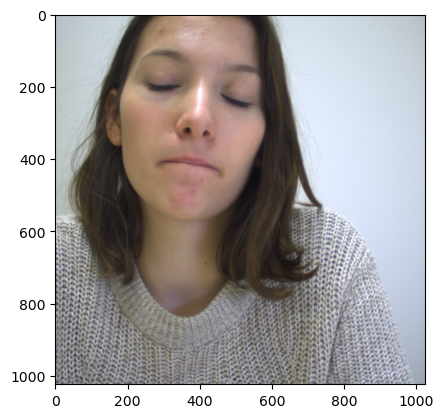

In [106]:
# import the necessary packages
from skimage.exposure import is_low_contrast
from numpy.linalg import norm
import cv2

videoIdx = 6
dataset_name = 'ubfc_phys'
dataset = steps.get_dataset(dataset_name)
videoFileName = dataset.getVideoFilename(videoIdx)
fps = vhr.extraction.get_fps(videoFileName)
print(videoFileName)
cam = cv2.VideoCapture(videoFileName) 
ret,frame = cam.read() 
image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
brightness = np.average(norm(image, axis=2)) / np.sqrt(3)
print(brightness)
plt.imshow(image)

In [52]:
def get_brightness(frame):
   """
      Convert image to greyscale, return average pixel brightness.
   """
   im =  Image.fromarray(frame).convert('L')
   stat = ImageStat.Stat(im)
   return stat.mean[0]

def change_brightness(img, value=0):
    """
      img: array
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def get_face(frame):
    image =  cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_classifier = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    face = face_classifier.detectMultiScale(
        image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40)
    )
    # for (x, y, w, h) in face:
    #     face = image[y:y+h, x:x+w]

    return face

target_brightness = 60
print("Entire Image: ", get_brightness(frame))
face = get_face(frame)
for (x, y, w, h) in face:
    face_image = image[y+int(h/4):y+int(3*h/4), x+int(w/4):x+int(3*w/4)]
brightness = get_brightness(face_image)
value = int(target_brightness - brightness)
print("Face brightness: ",brightness, value)  

brightned_image = change_brightness(frame, value=value)
print("Brightned Image: ", get_brightness(brightned_image))
plt.imshow(cv2.cvtColor(brightned_image, cv2.COLOR_BGR2RGB))

AttributeError: 'int' object has no attribute '__array_interface__'

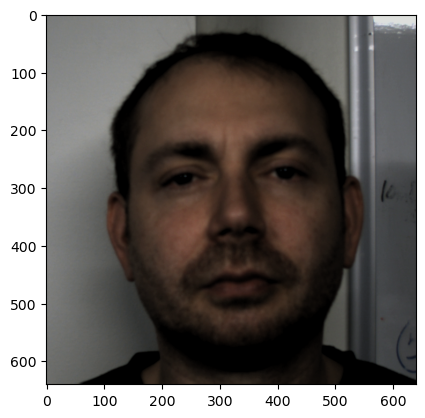

In [59]:
from PIL import Image, ImageStat

def get_brightness(frame):
   """
      Convert image to greyscale, return average pixel brightness.
   """
   im =  Image.fromarray(frame).convert('L')
   stat = ImageStat.Stat(im)
   return stat.mean[0]

def change_brightness(img, target_brightness=60):
    """
      img: array
    """
    brightness = get_brightness(img)
    value = int(target_brightness - brightness)

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

image = change_brightness(image, target_brightness=60)
plt.imshow(image)

In [61]:
dataset_name = 'lgi_ppgi' 
if dataset_name == 'ubfc_phys':
    result_path = f'D:/datasets_rppg/brightness_60/UBFC-Phys/'
elif dataset_name == 'mr_nirp':
    result_path = f'D:/datasets_rppg/brightness_60/MR_NIRP_indoor/'
elif dataset_name == 'lgi_ppgi':
    result_path = f'D:/datasets_rppg/brightness_60/lgi_ppgi/'

video_DIR, BVP_DIR = constants.get_dataset_paths(dataset_name)
videoFPS, sigvideoFPS = constants.get_fps(dataset_name)
dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames

for i, videoFileName in enumerate(allvideo):
    if dataset_name == 'lgi_ppgi' or dataset_name == 'mr_nirp' or  dataset_name == 'ubfc_phys':
        fname = videoFileName.split('\\')[-1][:-4]
    else:
        raise Exception('videoFileName for dataset not supported', dataset_name)

    # write also for non still videos just to keep videoIdx consistent
    if dataset_name.lower() == "ubfc_phys" and "T1" not in videoFileName:
        video = cv2.VideoWriter(result_path + f'{fname}.avi', cv2.VideoWriter_fourcc(*'XVID'), videoFPS, (0, 0))
        video.release()
        continue
    if dataset_name.lower() == "mr_nirp" and "still" not in videoFileName:
        video = cv2.VideoWriter(result_path + f'{fname}.avi', cv2.VideoWriter_fourcc(*'XVID'), videoFPS, (0, 0))
        video.release()
        continue
    if dataset_name.lower() == 'lgi_ppgi':
        result_path = f'D:/datasets_rppg/brightness_60/lgi_ppgi/'
        person, activity = videoFileName.split('\\')[-2].split('_')[0], videoFileName.split('\\')[-2].split('_')[1]
        if not os.path.exists(result_path + f'{person}/{person}_{activity}'):
            os.makedirs(result_path + f'{person}/{person}_{activity}')
        result_path = result_path + f'{person}/{person}_{activity}/'

    frame_count = 0
    total_brightness = 0.0
    nb_frames_minute = videoFPS * 60
    frames = []
    cap = cv2.VideoCapture(videoFileName)
    while cap.isOpened() and frame_count < nb_frames_minute:
        ret, frame = cap.read()
        if not ret:
            break
        frame = change_brightness(frame, target_brightness=60)
        frames.append(frame)
        frame_count += 1
    width, height = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    cap.release()

    video = cv2.VideoWriter(result_path + f'{fname}.avi', cv2.VideoWriter_fourcc(*'XVID'), videoFPS, (width, height))
    for frame in frames:
        video.write(frame)
    video.release()
    print("Completed ", result_path + fname)

Completed  D:/datasets_rppg/brightness_60/lgi_ppgi/alex/alex_gym/cv_camera_sensor_stream_handler
Completed  D:/datasets_rppg/brightness_60/lgi_ppgi/alex/alex_resting/cv_camera_sensor_stream_handler
Completed  D:/datasets_rppg/brightness_60/lgi_ppgi/alex/alex_rotation/cv_camera_sensor_stream_handler
Completed  D:/datasets_rppg/brightness_60/lgi_ppgi/alex/alex_talk/cv_camera_sensor_stream_handler
Completed  D:/datasets_rppg/brightness_60/lgi_ppgi/angelo/angelo_gym/cv_camera_sensor_stream_handler
Completed  D:/datasets_rppg/brightness_60/lgi_ppgi/angelo/angelo_resting/cv_camera_sensor_stream_handler
Completed  D:/datasets_rppg/brightness_60/lgi_ppgi/angelo/angelo_rotation/cv_camera_sensor_stream_handler
Completed  D:/datasets_rppg/brightness_60/lgi_ppgi/angelo/angelo_talk/cv_camera_sensor_stream_handler
Completed  D:/datasets_rppg/brightness_60/lgi_ppgi/cpi/cpi_gym/cv_camera_sensor_stream_handler
Completed  D:/datasets_rppg/brightness_60/lgi_ppgi/cpi/cpi_resting/cv_camera_sensor_stream_ha

KeyboardInterrupt: 

In [23]:
# change brightness to target_brightness for all frames in video
videoFileName = dataset.getVideoFilename(videoIdx)
cap = cv2.VideoCapture(videoFileName)
frame_count = 0
total_brightness = 0.0
nb_frames_minute = fps * 60
if dataset_name == 'lgi_ppgi' or dataset_name == 'mr_nirp' or  dataset_name == 'ubfc_phys':
    fname = videoFileName.split('\\')[-1][:-4]
else:
    raise Exception('videoFileName for dataset not supported', dataset_name)

frames = []
while cap.isOpened() and frame_count < nb_frames_minute:
    ret, frame = cap.read()
    if not ret:
        break
    frame = change_brightness(frame, target_brightness=60)
    frames.append(frame)
width, height = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
cap.release()


video = cv2.VideoWriter(f'D:/datasets_rppg/brightness_60/MR_NIRP_indoor/{fname}.avi', cv2.VideoWriter_fourcc(*'XVID'), fps,  (width, height))
for frame in frames:
    video.write(frame)
video.release()

 Check performance difference

In [169]:
# Before 

videoIdx = 6
winsize = 10
duration = 60
overlap = 0 
landmarks = ['glabella']
dataset_name = 'ubfc_phys'

videoFPS, sigFPS = constants.get_fps(dataset_name)
dataset = steps.get_dataset(dataset_name)
PPG_win, bpmGT, timesGT, videoFileName = steps.get_signal_data(videoIdx, dataset, dataset_name, winsize)
videoFileName = dataset.getVideoFilename(videoIdx)
print(videoFileName)
windowed_sig, timesES = steps.run_extraction(landmarks, videoFileName, roi_approach='landmark', sampling_method='random', nb_sample_points=2000, seconds=duration, winsize=winsize, stride=winsize-overlap)
windowed_sig = windowed_sig[:int(duration/winsize)]
timesES = timesES[:int(duration/winsize)]

res = steps.TestResult()
res, bvps_win, bvps_median = steps.get_bpm(res, fname, landmarks, windowed_sig, timesES, bpmGT, timesGT, PPG_win, videoFPS, sigFPS, dataset_name, roi_approach='landmark', methods=['cupy_CHROM'])
bvps_win = np.array(bvps_win)
df = res.dataFrame
df.head()

videoFileName :  s11
D:/datasets_rppg/UBFC-Phys\s11\vid_s11_T1.avi


,method,dataset,videoIdx,videoFilename,RMSE,MAE,PCC,CCC,SNR,MAX,MAD,bpmGT,bpmES,bpmES_mad,timeGT,timeES,landmarks,timePCC,timeDTW
0,cupy_CHROM,,,vid_s11_T1,[23.563480911873988],[16.03583984375],[-0.30046129793449233],[-0.2879915662641751],[8.860973119735718],[37.73435546875],,"[77.5, 78.0, 79.5, 81.0, 82.0, 82.0, 82.0, 82....","[82.3546875, 85.44298828125, 44.26564453125, 8...",,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0]","(glabella,)",-0.038587,1.778271


In [170]:
# After 

videoIdx = 0
winsize = 10
duration = 60
overlap = 0 
landmarks = ['glabella']
dataset_name = 'ubfc_phys'

videoFPS, sigFPS = constants.get_fps(dataset_name)
dataset = steps.get_dataset(dataset_name, video_DIR='D:/datasets_rppg/brightness_60/UBFC-Phys/')
# dataset = steps.get_dataset(dataset_name, video_DIR='D:/datasets_rppg/brightness_60/MR_NIRP_indoor/')
PPG_win, bpmGT, timesGT, videoFileName = steps.get_signal_data(videoIdx, dataset, dataset_name, winsize)
videoFileName = dataset.getVideoFilename(videoIdx)
print(videoFileName)
windowed_sig, timesES = steps.run_extraction(landmarks, videoFileName, roi_approach='landmark', sampling_method='random', nb_sample_points=2000, seconds=duration, winsize=winsize, stride=winsize-overlap)
windowed_sig = windowed_sig[:int(duration/winsize)]
timesES = timesES[:int(duration/winsize)]

res = steps.TestResult()
res, bvps_win, bvps_median = steps.get_bpm(res, fname, landmarks, windowed_sig, timesES, bpmGT, timesGT, PPG_win, videoFPS, sigFPS, dataset_name, roi_approach='landmark', methods=['cupy_CHROM'])
bvps_win = np.array(bvps_win)
df = res.dataFrame
df.head()

videoFileName :  D:/datasets_rppg/brightness_60/UBFC-Phys/vid_s11_T1.avi
D:/datasets_rppg/brightness_60/UBFC-Phys/vid_s11_T1.avi


,method,dataset,videoIdx,videoFilename,RMSE,MAE,PCC,CCC,SNR,MAX,MAD,bpmGT,bpmES,bpmES_mad,timeGT,timeES,landmarks,timePCC,timeDTW
0,cupy_CHROM,,,vid_s11_T1,[13.070059586106758],[10.564453125],[0.31502192508755583],[0.2996511603123131],[-2.6093968749046326],[20.969453125],,"[62.50000000000001, 63.5, 66.5, 69.5, 71.0, 72...","[86.472421875, 81.32525390624998, 87.501855468...",,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","(glabella,)",0.044009,2.508581
